# Pressor Distributions
- Ruoyi Jiang
- July 19, 2019
- Evaluation of the different pressor combinations used in MIMIC

In [1]:
library(dplyr)
library(tidyr)
library(ggplot2)
library(fasttime)
library(epitools)
library(boot)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Filtering criteria:
- Groupby continuous courses (<24 hour intervals between pressors not considered separate)
- Exclude those on pressors within 1 hr of hospital
- First pressor course

In [2]:
pressors_df <- read.csv('~/Projects/Haimovich_Pressors/collection/out/pressors.csv')

In [3]:
dim(pressors_df)

[1] 227645     11

In [328]:
pressors_df %>%
    filter(pressor == "central_line_durations") %>% head()

X,level_0,level_1,duration_hours,endtime,icustay_id,num,pressor,starttime,vasonum,ventnum
<int>,<fct>,<int>,<dbl>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<dbl>
30584,central_line_durations,0,70.91667,2181-11-28 20:59:00,200001,NA,central_line_durations,2181-11-25 22:04:00,NA,NA
30585,central_line_durations,1,134.00000,2199-08-08 15:00:00,200003,NA,central_line_durations,2199-08-03 01:00:00,NA,NA
30586,central_line_durations,2,37.75000,2189-12-02 08:00:00,200009,NA,central_line_durations,2189-11-30 18:15:00,NA,NA
30587,central_line_durations,3,19.68333,2132-08-05 20:36:00,200010,NA,central_line_durations,2132-08-05 00:55:00,NA,NA
30588,central_line_durations,4,23.76667,2114-12-27 22:46:00,200021,NA,central_line_durations,2114-12-26 23:00:00,NA,NA
30589,central_line_durations,5,9.30000,2127-03-04 01:18:00,200024,NA,central_line_durations,2127-03-03 16:00:00,NA,NA


In [83]:
pressors_df %>%
    filter(pressor == "ventdurations") %>% head()

X,level_0,level_1,duration_hours,endtime,icustay_id,num,pressor,starttime,vasonum,ventnum
<int>,<fct>,<int>,<dbl>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<dbl>
189130,ventdurations,0,91.00000,2199-08-07 13:00:00,200003,NA,ventdurations,2199-08-03 18:00:00,NA,1
189131,ventdurations,1,14.83333,2159-09-04 03:50:00,200006,NA,ventdurations,2159-09-03 13:00:00,NA,1
189132,ventdurations,2,15.83333,2189-12-01 10:00:00,200009,NA,ventdurations,2189-11-30 18:10:00,NA,1
189133,ventdurations,3,3.00000,2188-08-06 04:00:00,200011,NA,ventdurations,2188-08-06 01:00:00,NA,1
189134,ventdurations,4,18.75000,2105-02-17 18:00:00,200014,NA,ventdurations,2105-02-16 23:15:00,NA,1
189135,ventdurations,5,83.00000,2138-03-21 09:00:00,200017,NA,ventdurations,2138-03-17 22:00:00,NA,1


### Available pressor (and other infusions) choices

In [227]:
unique(pressors_df$pressor)

[1] adenosinedurations      arterial_line_durations central_line_durations 
 [4] crrtdurations           dobutaminedurations     dopaminedurations      
 [7] epinephrinedurations    isupreldurations        milrinonedurations     
[10] norepinephrinedurations phenylephrinedurations  vasopressindurations   
[13] vasopressordurations    ventdurations          
14 Levels: adenosinedurations ... ventdurations

In [544]:
pressor_choices <- c("norepinephrinedurations", "dopaminedurations", "phenylephrinedurations")

In [546]:
pressors_df %>%
    filter(pressor %in% pressor_choices)  %>%
    mutate(SHORT = duration_hours < 24) %>%
    group_by(SHORT, pressor) %>% 
    summarize(COUNT = n())

SHORT,pressor,COUNT
<lgl>,<fct>,<int>
FALSE,dopaminedurations,1122
FALSE,norepinephrinedurations,3407
FALSE,phenylephrinedurations,2739
TRUE,dopaminedurations,5402
TRUE,norepinephrinedurations,19781
TRUE,phenylephrinedurations,30402


# Histograms of pressor durations for norepi

Don't know how to automatically pick scale for object of type difftime. Defaulting to continuous.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 1254 rows containing non-finite values (stat_bin).”Warning message:
“Removed 1254 rows containing non-finite values (stat_density).”

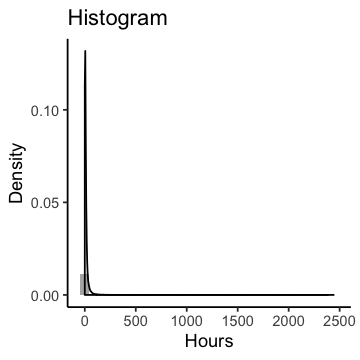

In [547]:
options(repr.plot.width=3, repr.plot.height=3)
pressors_df %>%
    filter(pressor %in% pressor_choices)  %>%
    mutate(DIFF = 
              difftime(fastPOSIXct(endtime), 
               fastPOSIXct(starttime), units="hours")) %>%
    ggplot(aes(x=DIFF)) +
        geom_histogram(aes(y=..density..), position="identity", alpha=0.5)+
        geom_density(alpha=0.6)+
        scale_color_manual(values=c("#999999", "#E69F00", "#56B4E9"))+
        scale_fill_manual(values=c("#999999", "#E69F00", "#56B4E9"))+
        labs(title="Histogram",x="Hours", y = "Density")+
        theme_classic()

Don't know how to automatically pick scale for object of type difftime. Defaulting to continuous.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


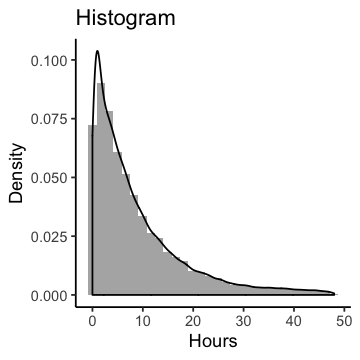

In [548]:
options(repr.plot.width=3, repr.plot.height=3)
pressors_df %>%
    filter(pressor %in% pressor_choices)  %>%
    mutate(DIFF = 
              difftime(fastPOSIXct(endtime), 
               fastPOSIXct(starttime), units="hours")) %>%
    filter(DIFF < 48) %>%
    ggplot(aes(x=DIFF)) +
        geom_histogram(aes(y=..density..), position="identity", alpha=0.5)+
        geom_density(alpha=0.6)+
        scale_color_manual(values=c("#999999", "#E69F00", "#56B4E9"))+
        scale_fill_manual(values=c("#999999", "#E69F00", "#56B4E9"))+
        labs(title="Histogram",x="Hours", y = "Density")+
        theme_classic()

### Join with icustay metadata

In [138]:
lengthstay_df <- read.csv('~/Projects/Haimovich_Pressors/collection/out/length_stay.csv') %>%
    rename(icustarttime = START, icuendtime = END)

In [139]:
lengthstay_df %>% head()

X,icustay_id,icustarttime,icuendtime,DIFF
<int>,<int>,<fct>,<fct>,<dbl>
1,200001,2181-11-25 19:06:00,2181-11-28 20:00:00,72.90000
2,200003,2199-08-02 19:15:00,2199-08-08 15:00:00,139.75000
3,200006,2159-09-03 12:30:00,2159-09-04 17:00:00,28.50000
4,200007,2109-02-17 09:00:00,2109-02-18 09:15:00,24.25000
5,200009,2189-11-30 11:43:00,2189-12-02 13:00:00,49.28333
6,200010,2132-08-05 00:39:00,2132-08-05 21:17:00,20.63333


In [1071]:
# filter by pressor and left join with lengthstay_df
input_df <- pressors_df %>%
    filter(pressor %in% pressor_choices)  %>%
    left_join(lengthstay_df, by = "icustay_id") %>%
    mutate(starttime = fastPOSIXct(starttime), endtime = fastPOSIXct(endtime), 
           icustarttime = fastPOSIXct(icustarttime), icuendtime = fastPOSIXct(icuendtime))

# Filters

#### Collapse pressor courses based on length of intervening time (<24 hrs)
- Any two courses with less than intervening 24 hours will be collapsed into a single course within an icustay

In [1072]:
max_intervening_hrs <- 24

# find the intervening time between courses (endtime of next course - endtime of course - duration of course)
# then determine if that length of time is >24 or <24 and mark it with a 0 if true, else a 1
# use a cumsum to create a new id separating courses that are separated by more than >24
input_list <- list()
for(pressor_choice in pressor_choices){
    input_list[[pressor_choice]] <- input_df %>%
        filter(pressor == pressor_choice) %>%
        group_by(icustay_id) %>%
        mutate(intervening_hours = difftime(endtime, lag(endtime), units="hours") - duration_hours) %>%
        rowwise() %>%
        mutate(increasing = if(intervening_hours < max_intervening_hrs | is.na(intervening_hours)){0}else(1)) %>%
        ungroup() %>%
        group_by(icustay_id) %>%
        mutate(continuous_course = cumsum(increasing)) %>% select(-intervening_hours, -increasing)
    cat(pressor_choice, '\n')
}

norepinephrinedurations 
dopaminedurations 
phenylephrinedurations 


In [1073]:
input_df <- bind_rows(input_list, .id="pressor_choice")

- the combination of **continuous course** and **icustay_id** (e.g. 200024, 0 for first row) now defines each pressor course

- assign boolean assessments after <24 hour intervals between pressors are removed
    1. more or less than 24 hours of pressor duration?
    2. is this the first pressor course?
    3. are pressors administered <1 hr of the icustay?

In [1075]:
# 1. more or less than 24 hours?
input_df <- input_df %>%
    group_by(icustay_id, continuous_course, pressor) %>%
    mutate(MORETHAN24HOURS = sum(duration_hours) > 24, 
           STATUS = if(sum(duration_hours) > 24){"MORETHAN24HOURS"}
           else if(sum(duration_hours) <= 24 & sum(duration_hours) > 6){"LESSTHAN24HOURS"}
           else if(sum(duration_hours) <= 6){"LESSTHAN6HOURS"}
               )

In [1076]:
# 2. first pressor course? (groupby icustay, filter min starttime == starttime)
input_df <- input_df %>%
    group_by(icustay_id, continuous_course, pressor) %>%
    mutate(coursestarttime = min(starttime)) %>%
    group_by(icustay_id) %>%
    mutate(FIRSTCOURSE = min(coursestarttime) == coursestarttime)

In [1077]:
# 3. pressors within 1 hr of icustay_id? (groupby icustay, filter max starttime - unique icustarttime > 1)
input_df <- input_df %>%
    group_by(icustay_id, continuous_course, pressor) %>%
    mutate(coursestarttime = min(starttime)) %>%
    group_by(icustay_id) %>%
    mutate(LESS1HOUR = difftime(min(coursestarttime), 
                         min(icustarttime)) < 1)

In [1078]:
# grouped by icustay_id + continuous_course + separate_course
input_df %>%
    group_by(LESS1HOUR, FIRSTCOURSE, MORETHAN24HOURS, pressor) %>%
    summarize(COUNT = n())

LESS1HOUR,FIRSTCOURSE,MORETHAN24HOURS,pressor,COUNT
<lgl>,<lgl>,<lgl>,<fct>,<int>
FALSE,FALSE,FALSE,dopaminedurations,740
FALSE,FALSE,FALSE,norepinephrinedurations,2340
FALSE,FALSE,FALSE,phenylephrinedurations,2994
FALSE,FALSE,TRUE,dopaminedurations,838
FALSE,FALSE,TRUE,norepinephrinedurations,6513
FALSE,FALSE,TRUE,phenylephrinedurations,5674
FALSE,TRUE,FALSE,dopaminedurations,2124
FALSE,TRUE,FALSE,norepinephrinedurations,3782
FALSE,TRUE,FALSE,phenylephrinedurations,11821


In [1079]:
# With filters grouped by icustay_id + continuous_course
input_df %>%
    mutate(course_id = paste(icustay_id, continuous_course, sep = ",")) %>%
    group_by(LESS1HOUR, FIRSTCOURSE, MORETHAN24HOURS, pressor) %>%
    summarize(COUNT = length(unique(course_id)))

LESS1HOUR,FIRSTCOURSE,MORETHAN24HOURS,pressor,COUNT
<lgl>,<lgl>,<lgl>,<fct>,<int>
FALSE,FALSE,FALSE,dopaminedurations,571
FALSE,FALSE,FALSE,norepinephrinedurations,1592
FALSE,FALSE,FALSE,phenylephrinedurations,1859
FALSE,FALSE,TRUE,dopaminedurations,302
FALSE,FALSE,TRUE,norepinephrinedurations,1482
FALSE,FALSE,TRUE,phenylephrinedurations,1097
FALSE,TRUE,FALSE,dopaminedurations,1694
FALSE,TRUE,FALSE,norepinephrinedurations,2611
FALSE,TRUE,FALSE,phenylephrinedurations,6812


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 1 rows containing non-finite values (stat_bin).”Warning message:
“Removed 1 rows containing non-finite values (stat_density).”Warning message:
“Removed 2 rows containing missing values (geom_bar).”

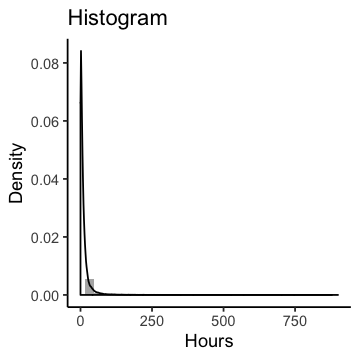

In [1080]:
options(repr.plot.width=3, repr.plot.height=3)
input_df %>%
    ggplot(aes(x=duration_hours)) +
        geom_histogram(aes(y=..density..), position="identity", alpha=0.5)+
        geom_density(alpha=0.6)+
        scale_color_manual(values=c("#999999", "#E69F00", "#56B4E9"))+
        scale_fill_manual(values=c("#999999", "#E69F00", "#56B4E9"))+
        labs(title="Histogram",x="Hours", y = "Density")+
        theme_classic() + xlim(0, 900)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 3 rows containing non-finite values (stat_bin).”Warning message:
“Removed 3 rows containing non-finite values (stat_density).”Warning message:
“Removed 2 rows containing missing values (geom_bar).”

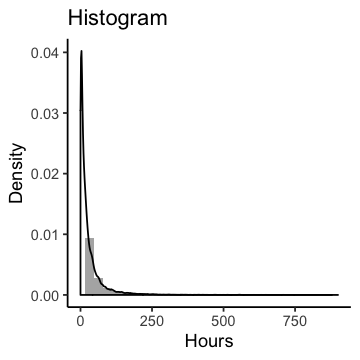

In [1082]:
options(repr.plot.width=3, repr.plot.height=3)
input_df %>%
    group_by(icustay_id, continuous_course, pressor) %>%
    summarize(duration_hours = sum(duration_hours)) %>%
    ggplot(aes(x=duration_hours)) +
        geom_histogram(aes(y=..density..), position="identity", alpha=0.5)+
        geom_density(alpha=0.6)+
        scale_color_manual(values=c("#999999", "#E69F00", "#56B4E9"))+
        scale_fill_manual(values=c("#999999", "#E69F00", "#56B4E9"))+
        labs(title="Histogram",x="Hours", y = "Density")+
        theme_classic() + xlim(0, 900)

In [132]:
#write.csv(input_df, '~/Projects/Haimovich_Pressors/collection/out/pressors_filtered.csv')

### Mortality filter
- Remove patients who stopped using pressors because death (merge with pressors_df by icustay_id, filter if pressor course end time == or is close to deathtime)

In [998]:
races <- c("ASIAN", "BLACK", "HISPANIC", "WHITE", "OTHER")

simplifyRace <- function(ethnicity){
    if(grepl("ASIAN", ethnicity)){return("ASIAN")}
    else if(grepl("BLACK", ethnicity)){return("BLACK")}
    else if(grepl("HISPANIC", ethnicity)){return("HISPANIC")}
    else if(grepl("WHITE", ethnicity)){return("WHITE")}
    else{return("OTHER")}
}

In [999]:
sepsis_regex <- c('SEPSIS', 'SEPTIC', 'CHOLANGITIS', 'UROSEPSIS')

infection_regex <- c('PNEUMONIA', 'INFECTION',  
  'CELULLITIS', 'FASCITIS', 'INFECTED', 'BACTER', 'PNEMONIA', 'ABSCESS', 'NEPHRITIS')

cardiac_regex <- c('HEART', 'CORONARY', 'VENTRICULAR')

simplifyDiagnosis <- function(diagnosis){
    if(any(sapply(sepsis_regex, function(x) grepl(x, diagnosis)))){return("SEPSIS")}
    else if(any(sapply(infection_regex, function(x) grepl(x, diagnosis)))){return("INFECTION")}
    else if(any(sapply(cardiac_regex, function(x) grepl(x, diagnosis)))){return("CARDIAC")}
    else{return("OTHER DIAGNOSIS")}
}

In [1083]:
icustays_df <- read.csv('~/Projects/Haimovich_Pressors/collection/out/icustays.csv')

In [1084]:
admissions_df <- read.csv('~/Projects/Haimovich_Pressors/collection/out/admissions.csv')

In [1085]:
patients_df <- read.csv('~/Projects/Haimovich_Pressors/collection/out/patients.csv')

In [1086]:
intub_df <- pressors_df %>%
    filter(pressor == "ventdurations") 

cvc_df <- pressors_df %>%
    filter(pressor == "central_line_durations") 

In [1087]:
nonvitals_predictor_df <- icustays_df %>%
    select(hadm_id, icustay_id, first_careunit, last_careunit) %>%
    left_join(admissions_df, by = 'hadm_id') %>%
    left_join(patients_df, by = 'subject_id') %>%
    mutate(intub = icustay_id %in% intub_df$icustay_id, cvc = icustay_id %in% cvc_df$icustay_id) %>%
    mutate(deathtime = fastPOSIXct(deathtime), admittime = fastPOSIXct(admittime), dob = fastPOSIXct(dob)) %>%
    mutate(age = difftime(admittime, dob, units="weeks")/52.25, age_cohort = as.numeric(round(age, digits = -1))) %>% 
    rowwise() %>%
    mutate(simple_race = simplifyRace(ethnicity)) %>%
    mutate(simple_diagnosis = simplifyDiagnosis(diagnosis))

In [1088]:
#NA means the stay did not end in death
#ICUSTAYS where patient was discharged after death? (TRUE)
nonvitals_predictor_df  %>%
    mutate(MORTALITYERROR = difftime(deathtime, dischtime, units = "mins") < 0) %>%
    group_by(MORTALITYERROR) %>%
    summarize(COUNT = n())

Warning message:
“Grouping rowwise data frame strips rowwise nature”

MORTALITYERROR,COUNT
<lgl>,<int>
FALSE,40
TRUE,6422
NA,55070


In [1089]:
#NA means the stay did not end in death
#ICUSTAYS where patient was admitted after death? (TRUE)
nonvitals_predictor_df  %>%
    mutate(MORTALITYERROR = difftime(deathtime, admittime, units = "mins") < 0) %>%
    group_by(MORTALITYERROR) %>%
    summarize(COUNT = n())

Warning message:
“Grouping rowwise data frame strips rowwise nature”

MORTALITYERROR,COUNT
<lgl>,<int>
FALSE,6384
TRUE,78
NA,55070


In [1090]:
#Examples
nonvitals_predictor_df  %>%
    filter(difftime(deathtime, admittime, units = "mins") < 0) %>%
    head(5)

hadm_id,icustay_id,first_careunit,last_careunit,X.x,row_id.x,subject_id,admittime,dischtime,deathtime,⋯,dod,dod_hosp,dod_ssn,expire_flag,intub,cvc,age,age_cohort,simple_race,simple_diagnosis
<int>,<int>,<fct>,<fct>,<int>,<int>,<int>,<dttm>,<fct>,<dttm>,⋯,<fct>,<fct>,<fct>,<int>,<lgl>,<lgl>,<drtn>,<dbl>,<chr>,<chr>
102631,246694,CSRU,CSRU,456,237,181,2153-10-12 05:49:00,2153-10-12 06:29:00,2153-10-12 02:29:00,⋯,2153-10-12,2153-10-12,2153-10-12,1,FALSE,FALSE,65.12757082 weeks,70,WHITE,OTHER DIAGNOSIS
138015,298263,NICU,NICU,1911,1640,1334,2137-09-02 10:43:00,2137-09-02 12:00:00,2137-09-02 08:00:00,⋯,2137-09-02,2137-09-02,,1,TRUE,FALSE,0.00167654 weeks,0,WHITE,OTHER DIAGNOSIS
181430,291798,SICU,SICU,1970,1699,1381,2189-01-02 09:25:00,2189-01-02 12:00:00,2189-01-02 07:00:00,⋯,2189-01-02,2189-01-02,2189-01-02,1,TRUE,FALSE,81.36049404 weeks,80,WHITE,OTHER DIAGNOSIS
187482,213831,MICU,MICU,693,644,516,2197-07-31 16:18:00,2197-07-31 01:10:00,2197-07-30 21:10:00,⋯,2197-07-31,2197-07-31,2197-07-31,1,FALSE,FALSE,70.88679654 weeks,70,OTHER,OTHER DIAGNOSIS
190088,293048,CCU,CCU,3624,3447,2858,2108-09-25 11:29:00,2108-09-25 12:00:00,2108-09-25 08:00:00,⋯,2108-09-25,2108-09-25,2108-09-25,1,TRUE,FALSE,82.42418356 weeks,80,WHITE,OTHER DIAGNOSIS


### Setting a mortality filter

In [1091]:
# Icustays where patients received pressors after death (TRUE)
input_df %>%
    ungroup() %>%
    left_join(nonvitals_predictor_df, by = "icustay_id") %>%
    mutate(STOPMORTALITY = difftime(deathtime, endtime, units = "mins")) %>% 
    group_by(STOPMORTALITY < 0) %>%
    summarize(COUNT = length(unique(icustay_id)))

STOPMORTALITY < 0,COUNT
<lgl>,<int>
FALSE,3416
TRUE,658
NA,13640


In [1092]:
### if I do not ignore for these unusual cases
input_df %>%
    ungroup() %>%
    left_join(nonvitals_predictor_df, by = "icustay_id") %>%
    group_by(icustay_id, continuous_course, pressor) %>%
    mutate(STOPMORTALITY = difftime(deathtime, max(endtime), units = "mins")) %>% 
    mutate(STOPMORTALITY = STOPMORTALITY < 5) %>%
    group_by(STOPMORTALITY) %>%
    summarize(COUNT = n())

STOPMORTALITY,COUNT
<lgl>,<int>
FALSE,16598
TRUE,3584
NA,42671


In [1093]:
### if I do ignore these unusual cases
input_df %>%
    ungroup() %>%
    left_join(nonvitals_predictor_df, by = "icustay_id") %>%
    group_by(icustay_id, continuous_course, pressor) %>%
    mutate(STOPMORTALITY = difftime(deathtime, max(endtime), units = "mins")) %>% 
    mutate(STOPMORTALITY = STOPMORTALITY > 0 &  STOPMORTALITY < 5) %>%
    group_by(STOPMORTALITY) %>%
    summarize(COUNT = n())

STOPMORTALITY,COUNT
<lgl>,<int>
FALSE,19985
TRUE,197
NA,42671


In [531]:
# # ignore NAs (patient did not die), or patient death did not correspond to end of pressor course
# # do not remove unusual cases
# input_death_df <- input_df %>%
#     ungroup() %>%
#     left_join(nonvitals_predictor_df, by = "icustay_id") %>%
#     group_by(icustay_id, continuous_course, pressor) %>%
#     mutate(STOPMORTALITY = difftime(deathtime, max(endtime), units = "mins")) %>% 
#     mutate(STOPMORTALITY = !(!(STOPMORTALITY < 5) | is.na(STOPMORTALITY)))

In [1094]:
# ignore NAs (patient did not die), or patient death did not correspond to end of pressor course
# remove unusual cases
input_death_df <- input_df %>%
    ungroup() %>%
    left_join(nonvitals_predictor_df, by = "icustay_id") %>%
    group_by(icustay_id, continuous_course, pressor) %>%
    mutate(STOPMORTALITY = difftime(deathtime, max(endtime), units = "mins")) %>% 
    mutate(STOPMORTALITY = !(!(STOPMORTALITY > 0 &  STOPMORTALITY < 5) | is.na(STOPMORTALITY)))

### Exclude NICU (all NICU was already excluded by pressor usage)

In [1154]:
input_death_df %>%
    mutate(NICUSTAY = first_careunit == "NICU") %>%
    mutate(course_id = paste(icustay_id, continuous_course, sep = ",")) %>%
    group_by(LESS1HOUR, FIRSTCOURSE, STOPMORTALITY, MORETHAN24HOURS, NICUSTAY) %>%
    summarize(COUNT = length(unique(course_id)))

LESS1HOUR,FIRSTCOURSE,STOPMORTALITY,MORETHAN24HOURS,NICUSTAY,COUNT
<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<int>
FALSE,FALSE,FALSE,FALSE,FALSE,3696
FALSE,FALSE,FALSE,FALSE,TRUE,6
FALSE,FALSE,FALSE,TRUE,FALSE,2677
FALSE,FALSE,FALSE,TRUE,TRUE,18
FALSE,FALSE,TRUE,FALSE,FALSE,21
FALSE,FALSE,TRUE,TRUE,FALSE,17
FALSE,TRUE,FALSE,FALSE,FALSE,10778
FALSE,TRUE,FALSE,FALSE,TRUE,90
FALSE,TRUE,FALSE,TRUE,FALSE,4785


In [1155]:
input_death_df <- input_death_df %>%
    filter(first_careunit != "NICU")

### Use filters, clean predictors

In [1156]:
output_df <- input_death_df %>%
    mutate(course_id = paste(icustay_id, continuous_course, sep = ",")) %>%
    group_by(course_id, pressor) %>%
    mutate(starttime = min(starttime), endtime = max(endtime)) %>%
    filter(!LESS1HOUR, FIRSTCOURSE, !STOPMORTALITY) 

In [1157]:
# collapse so each row is a course_id
output_df <- output_df %>%
    group_by(course_id, pressor) %>%
    summarize(
            STATUS = unique(STATUS)[1], 
            MORETHAN24HOURS = unique(MORETHAN24HOURS)[1], 
            simple_diagnosis = unique(simple_diagnosis)[1], 
            simple_race = unique(simple_race)[1], 
            age = unique(age_cohort)[1], 
            age_cohort = unique(age)[1], 
            cvc = unique(cvc)[1],
            intub = unique(intub)[1],
            first_careunit = unique(first_careunit)[1],
            gender = unique(gender)[1],
            icustay_id = unique(icustay_id)[1],
            starttime = min(starttime), 
            endtime = max(endtime)
    )

In [1158]:
dim(output_df)

[1] 15853    15

# Table 1 (RR Analysis)

Second: Let’s pause the sophisticated (and more interesting) analysis to build out our manuscript table 1 and supp tables 1-3. Details in the doc, but I imagine this as a classic table 1 where you show group characteristics. Hopefully R has a straight-forward way of dumping these out. (https://cran.r-project.org/web/packages/tableone/vignettes/introduction.html)

 

T1: composite of levophed, dopamine, phenylephrine X [all patients; single pressor < 6 hours; single pressor < 24 hours; single pressor > 24 hours or multiple pressors at any point]

S1-S3: blow-out of levophed, dopamine, phenylephrine X [all patients; single pressor < 6 hours; single pressor < 24 hours; single pressor > 24 hours or multiple pressors at any point]

P-values to compare < 24 vs > 24 or multiple pressors

+/- Relative risks for categorical variables?

 

In [1159]:
t1_df <- output_df %>% 
    group_by(STATUS) %>%
    summarize(COUNT = n(), 
              AGE_MEAN = as.numeric(mean(age, na.rm=TRUE)), AGE_SD = sd(age, na.rm=TRUE),
              FEMALE_SUM = sum(gender == 'F'),
              FEMALE_FRAC = sum(gender == 'F')/n(),
              WHITE_SUM = sum(simple_race == 'WHITE'),
              WHITE_FRAC = sum(simple_race == 'WHITE')/n(),
              BLACK_SUM = sum(simple_race == 'BLACK'),
              BLACK_FRAC = sum(simple_race == 'BLACK')/n(),
              HISPANIC_SUM = sum(simple_race == 'HISPANIC'),
              HISPANIC_FRAC = sum(simple_race == 'HISPANIC')/n(),
              ASIAN_SUM = sum(simple_race == 'ASIAN'),
              ASIAN_FRAC = sum(simple_race == 'ASIAN')/n(),
              MICU_SUM = sum(first_careunit == 'MICU'),
              MICU_FRAC = sum(first_careunit == 'MICU')/n(),
              SICU_SUM = sum(first_careunit == 'SICU'),
              SICU_FRAC = sum(first_careunit == 'SICU')/n(),
              CCU_SUM = sum(first_careunit == 'CCU'),
              CCU_FRAC = sum(first_careunit == 'CCU')/n(),
              TSICU_SUM = sum(first_careunit == 'TSICU'),
              TSICU_FRAC = sum(first_careunit == 'TSICU')/n(),
              CSRU_SUM = sum(first_careunit == 'CSRU'),
              CSRU_FRAC = sum(first_careunit == 'CSRU')/n(),
              SEPSIS_SUM = sum(simple_diagnosis == "SEPSIS"),
              SEPSIS_FRAC = sum(simple_diagnosis == "SEPSIS")/n(),
              INFX_SUM = sum(simple_diagnosis == "INFECTION"),
              INFX_FRAC = sum(simple_diagnosis == "INFECTION")/n(),
              CARDIAC_SUM = sum(simple_diagnosis == "CARDIAC"),
              CARDIAC_FRAC = sum(simple_diagnosis == "CARDIAC")/n(),
              CVC_SUM = sum(cvc == "TRUE", na.rm=TRUE),
              CVC_FRAC = sum(cvc == "TRUE", na.rm=TRUE)/n(),
              INTUB_SUM = sum(intub == "TRUE", na.rm=TRUE),
              INTUB_FRAC = sum(intub == "TRUE", na.rm=TRUE)/n()
             ) %>% t()

In [1160]:
colnames(t1_df) <- t1_df[1,]

In [1161]:
t1_df

,LESSTHAN24HOURS,LESSTHAN6HOURS,MORETHAN24HOURS
STATUS,LESSTHAN24HOURS,LESSTHAN6HOURS,MORETHAN24HOURS
COUNT,5598,5407,4848
AGE_MEAN,65.71429,66.29365,65.21121
AGE_SD,14.33112,14.47993,14.48098
FEMALE_SUM,2133,2258,2002
FEMALE_FRAC,0.3810289,0.4176068,0.4129538
WHITE_SUM,4008,3889,3439
WHITE_FRAC,0.7159700,0.7192528,0.7093647
BLACK_SUM,323,364,319
BLACK_FRAC,0.05769918,0.06732014,0.06580033


### Supplement 1-3

In [1175]:
s1_3_df <- output_df %>% 
    group_by(STATUS, pressor) %>%
    summarize(COUNT = n(), 
              AGE_MEAN = as.numeric(mean(age, na.rm=TRUE)), AGE_SD = sd(age, na.rm=TRUE),
              FEMALE_SUM = sum(gender == 'F'),
              FEMALE_FRAC = sum(gender == 'F')/n(),
              WHITE_SUM = sum(simple_race == 'WHITE'),
              WHITE_FRAC = sum(simple_race == 'WHITE')/n(),
              BLACK_SUM = sum(simple_race == 'BLACK'),
              BLACK_FRAC = sum(simple_race == 'BLACK')/n(),
              HISPANIC_SUM = sum(simple_race == 'HISPANIC'),
              HISPANIC_FRAC = sum(simple_race == 'HISPANIC')/n(),
              ASIAN_SUM = sum(simple_race == 'ASIAN'),
              ASIAN_FRAC = sum(simple_race == 'ASIAN')/n(),
              MICU_SUM = sum(first_careunit == 'MICU'),
              MICU_FRAC = sum(first_careunit == 'MICU')/n(),
              SICU_SUM = sum(first_careunit == 'SICU'),
              SICU_FRAC = sum(first_careunit == 'SICU')/n(),
              CCU_SUM = sum(first_careunit == 'CCU'),
              CCU_FRAC = sum(first_careunit == 'CCU')/n(),
              TSICU_SUM = sum(first_careunit == 'TSICU'),
              TSICU_FRAC = sum(first_careunit == 'TSICU')/n(),
              CSRU_SUM = sum(first_careunit == 'CSRU'),
              CSRU_FRAC = sum(first_careunit == 'CSRU')/n(),
              SEPSIS_SUM = sum(simple_diagnosis == "SEPSIS"),
              SEPSIS_FRAC = sum(simple_diagnosis == "SEPSIS")/n(),
              INFX_SUM = sum(simple_diagnosis == "INFECTION"),
              INFX_FRAC = sum(simple_diagnosis == "INFECTION")/n(),
              CARDIAC_SUM = sum(simple_diagnosis == "CARDIAC"),
              CARDIAC_FRAC = sum(simple_diagnosis == "CARDIAC")/n(),
              CVC_SUM = sum(cvc == "TRUE", na.rm=TRUE),
              CVC_FRAC = sum(cvc == "TRUE", na.rm=TRUE)/n(),
              INTUB_SUM = sum(intub == "TRUE", na.rm=TRUE),
              INTUB_FRAC = sum(intub == "TRUE", na.rm=TRUE)/n()
             ) %>% t()

In [1176]:
colnames(s1_3_df) <- s1_3_df[1,]

In [1177]:
s1_3_df

,LESSTHAN24HOURS,LESSTHAN24HOURS,LESSTHAN24HOURS,LESSTHAN6HOURS,LESSTHAN6HOURS,LESSTHAN6HOURS,MORETHAN24HOURS,MORETHAN24HOURS,MORETHAN24HOURS
STATUS,LESSTHAN24HOURS,LESSTHAN24HOURS,LESSTHAN24HOURS,LESSTHAN6HOURS,LESSTHAN6HOURS,LESSTHAN6HOURS,MORETHAN24HOURS,MORETHAN24HOURS,MORETHAN24HOURS
pressor,dopaminedurations,norepinephrinedurations,phenylephrinedurations,dopaminedurations,norepinephrinedurations,phenylephrinedurations,dopaminedurations,norepinephrinedurations,phenylephrinedurations
COUNT,697,1548,3353,903,1053,3451,623,1846,2379
AGE_MEAN,67.92663,66.15543,65.09732,67.78580,66.04628,65.99762,69.47552,64.32555,64.82908
AGE_SD,14.44968,14.74278,14.07711,14.11339,15.36275,14.28056,13.03657,15.07623,14.18046
FEMALE_SUM,335,659,1139,431,471,1356,257,803,942
FEMALE_FRAC,0.4806313,0.4257106,0.3396958,0.4772979,0.4472934,0.3929296,0.4125201,0.4349946,0.3959647
WHITE_SUM,491,1075,2442,623,746,2520,422,1328,1689
WHITE_FRAC,0.7044476,0.6944444,0.7283030,0.6899225,0.7084520,0.7302231,0.6773676,0.7193933,0.7099622
BLACK_SUM,56,128,139,77,106,181,49,166,104


# Categorical Predictors

In [1167]:
calculatePredictors <- function(df){
    all_rr_list <- list()

    # gender
    output <- df %>%
        group_by(MORETHAN24HOURS, gender) %>%
        summarize(COUNT = n()) %>%
        spread(MORETHAN24HOURS, COUNT) %>%
        tibble::column_to_rownames("gender") %>%
        as.matrix() %>% riskratio()

    all_rr_list[['MALE_RR']] <- output$measure %>%
            data.frame() %>%
            tibble::rownames_to_column("FILTER") %>% filter(FILTER == 'M') %>%
            mutate(ID = "M", p = output$p.value["M","fisher.exact"])


    # race
    rr_list <- list()
    for(race in races){
       output <- df %>%
            rowwise() %>%
            group_by(MORETHAN24HOURS, simple_race) %>%
            summarize(COUNT = n()) %>%
            mutate(RACE_BOOL = simple_race == race) %>%
            group_by(RACE_BOOL, MORETHAN24HOURS) %>%
            summarize(COUNT = sum(COUNT)) %>%
            spread(MORETHAN24HOURS, COUNT) %>%
            tibble::column_to_rownames("RACE_BOOL") %>%
            as.matrix() %>% riskratio() 
        rr_list[[race]] <- output$measure %>%
            data.frame() %>%
            tibble::rownames_to_column("FILTER") %>% filter(FILTER == 'TRUE') %>%
            mutate(ID = race, p = output$p.value["TRUE","fisher.exact"])
    }


    all_rr_list[['RACE_RR']] <- bind_rows(rr_list)


    # age
    age_df <- df %>%
        group_by(MORETHAN24HOURS, age_cohort) %>%
        summarize(COUNT = n()) %>%
        drop_na(age_cohort)

    rr_list <- list()
    for(ac in unique(age_df$age_cohort)){
       if(ac != 0){
           output <- age_df %>%
                mutate(AGE_BOOL = age_cohort == ac) %>%
                group_by(AGE_BOOL, MORETHAN24HOURS) %>%
                summarize(COUNT = sum(COUNT)) %>%
                spread(MORETHAN24HOURS, COUNT) %>%
                tibble::column_to_rownames("AGE_BOOL") %>%
                as.matrix() %>% riskratio() 

            rr_list[[ac]] <- output$measure %>%
                data.frame() %>%
                tibble::rownames_to_column("FILTER") %>% filter(FILTER == 'TRUE') %>%
                mutate(ID = as.character(ac), p = output$p.value["TRUE","fisher.exact"])
       }  
    }

    all_rr_list[['AGE_RR']] <- bind_rows(rr_list)


    # diagnosis
    diagnosis_df <- df %>%
        rowwise() %>%
        group_by(simple_diagnosis, MORETHAN24HOURS) %>%
        summarize(COUNT = n()) 

    rr_list <- list()
    for(s_d in unique(diagnosis_df$simple_diagnosis)){
       output <- diagnosis_df %>%
            mutate(DX_BOOL = simple_diagnosis == s_d) %>%
            group_by(DX_BOOL, MORETHAN24HOURS) %>%
            summarize(COUNT = sum(COUNT)) %>%
            spread(MORETHAN24HOURS, COUNT) %>%
            tibble::column_to_rownames("DX_BOOL") %>%
            as.matrix() %>% riskratio() 
        rr_list[[s_d]] <- output$measure %>%
            data.frame() %>%
            tibble::rownames_to_column("FILTER") %>% filter(FILTER == 'TRUE') %>%
            mutate(ID = s_d, p = output$p.value["TRUE","fisher.exact"])
    }

    all_rr_list[['DIAGNOSIS_RR']] <- bind_rows(rr_list)


    # careunit
    careunit_df <- df %>%
        group_by(MORETHAN24HOURS, first_careunit) %>%
        summarize(COUNT = n())

    rr_list <- list()
    for(cu in unique(careunit_df$first_careunit)){
       output <- careunit_df%>%
            mutate(CU_BOOL = first_careunit == cu) %>%
            group_by(CU_BOOL, MORETHAN24HOURS) %>%
            summarize(COUNT = sum(COUNT)) %>%
            spread(MORETHAN24HOURS, COUNT) %>%
            tibble::column_to_rownames("CU_BOOL") %>%
            as.matrix() %>% riskratio() 
        rr_list[[cu]] <- output$measure %>%
            data.frame() %>%
            tibble::rownames_to_column("FILTER") %>% filter(FILTER == 'TRUE') %>%
            mutate(ID = cu, p = output$p.value["TRUE","fisher.exact"])
    }

    all_rr_list[['CAREUNIT_RR']] <- bind_rows(rr_list)


    # intub
    output <- df %>%
        group_by(MORETHAN24HOURS, intub) %>%
        summarize(COUNT = n()) %>%
        spread(MORETHAN24HOURS, COUNT) %>%
        tibble::column_to_rownames("intub") %>%
        as.matrix() %>% riskratio()

    all_rr_list[['INTUB_RR']] <- output$measure %>%
            data.frame() %>%
            tibble::rownames_to_column("FILTER") %>% filter(FILTER == 'TRUE') %>%
            mutate(ID = "INTUB", p = output$p.value["TRUE","fisher.exact"])

    # cvc
    output <- df %>%
        group_by(MORETHAN24HOURS, cvc) %>%
        summarize(COUNT = n()) %>%
        spread(MORETHAN24HOURS, COUNT) %>%
        tibble::column_to_rownames("cvc") %>%
        as.matrix() %>% riskratio()

    all_rr_list[['CVC_RR']] <- output$measure %>%
            data.frame() %>%
            tibble::rownames_to_column("FILTER") %>% filter(FILTER == 'TRUE') %>%
            mutate(ID = "CVC", p = output$p.value["TRUE","fisher.exact"])


    # combined
    all_rr_df <- bind_rows(all_rr_list, .id="TYPE") %>%
        mutate(significant = p < 0.05)
    
    return(all_rr_df)
}


# Table 1 (RR significance)

In [1168]:
calculatePredictors(output_df)

Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message:
“Grouping rowwise data frame strips rowwise nature”

TYPE,FILTER,estimate,lower,upper,ID,p,significant
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<lgl>
MALE_RR,M,0.9606925,0.9160746,1.0074835,M,1.022581e-01,FALSE
RACE_RR,TRUE,0.8538936,0.7191618,1.0138668,ASIAN,6.900468e-02,FALSE
RACE_RR,TRUE,1.0395110,0.9463643,1.1418257,BLACK,4.366796e-01,FALSE
RACE_RR,TRUE,0.8817861,0.7498411,1.0369485,HISPANIC,1.252525e-01,FALSE
RACE_RR,TRUE,0.9725489,0.9237140,1.0239655,WHITE,2.936568e-01,FALSE
RACE_RR,TRUE,1.0686112,1.0062008,1.1348927,OTHER,3.384378e-02,TRUE
AGE_RR,TRUE,1.0222441,0.8183056,1.2770083,20,8.682009e-01,FALSE
AGE_RR,TRUE,1.1039998,0.9449763,1.2897843,30,2.211771e-01,FALSE
AGE_RR,TRUE,1.0585757,0.9503296,1.1791513,40,3.041662e-01,FALSE


### Supplement 1-3

In [1170]:
pressor_rr_list <- list()
for(pressor_choice in pressor_choices){
    pressor_rr_list[[pressor_choice]] <- output_df %>%
        filter(pressor == pressor_choice) %>%
        calculatePredictors()
}

Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message in chisq.test(xx, correct = correction):
“Chi-squared approximation may be incorrect”Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message

In [1171]:
pressor_rr_df <- bind_rows(pressor_rr_list, .id="pressor")

In [1172]:
pressor_rr_df

pressor,TYPE,FILTER,estimate,lower,upper,ID,p,significant
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<lgl>
norepinephrinedurations,MALE_RR,M,0.9987007,0.9308398,1.0715088,M,9.755196e-01,FALSE
norepinephrinedurations,RACE_RR,TRUE,0.8125458,0.6300305,1.0479344,ASIAN,1.070907e-01,FALSE
norepinephrinedurations,RACE_RR,TRUE,0.9997054,0.8849201,1.1293798,BLACK,1.000000e+00,FALSE
norepinephrinedurations,RACE_RR,TRUE,0.8983867,0.7073216,1.1410634,HISPANIC,3.891749e-01,FALSE
norepinephrinedurations,RACE_RR,TRUE,1.0567454,0.9771693,1.1428017,WHITE,1.699971e-01,FALSE
norepinephrinedurations,RACE_RR,TRUE,0.9701088,0.8781246,1.0717285,OTHER,5.791226e-01,FALSE
norepinephrinedurations,AGE_RR,TRUE,1.0694181,0.7971248,1.4347252,20,6.839022e-01,FALSE
norepinephrinedurations,AGE_RR,TRUE,1.1233746,0.9165693,1.3768413,30,2.813284e-01,FALSE
norepinephrinedurations,AGE_RR,TRUE,1.0942546,0.9431415,1.2695795,40,2.634795e-01,FALSE


# Figure 1 Plotting RR

Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message:
“Grouping rowwise data frame strips rowwise nature”

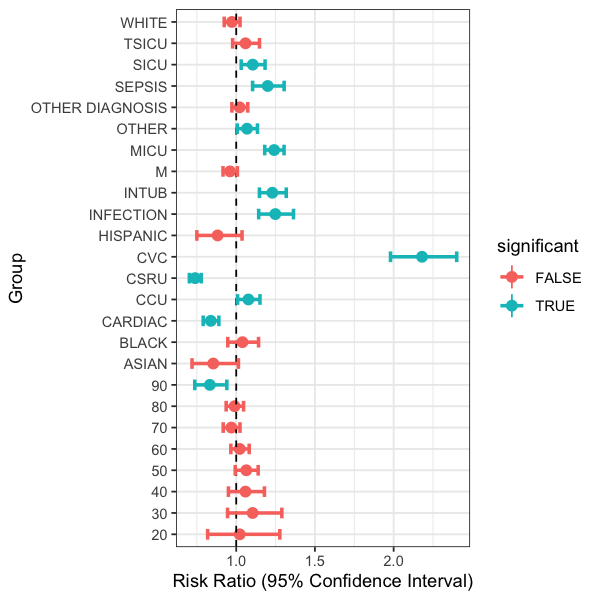

In [1169]:
options(repr.plot.width=5, repr.plot.height=5)
p = ggplot(data=calculatePredictors(output_df),
    aes(x = ID,y = estimate, ymin = lower, ymax = upper ))+
    geom_pointrange(aes(col=significant))+
    geom_hline(yintercept =1, linetype=2)+
    xlab('Group')+ ylab("Risk Ratio (95% Confidence Interval)")+
    geom_errorbar(aes(ymin=lower, ymax=upper,col=significant),width=0.5,cex=1)+ 
    theme_bw() +
    coord_flip()
plot(p)

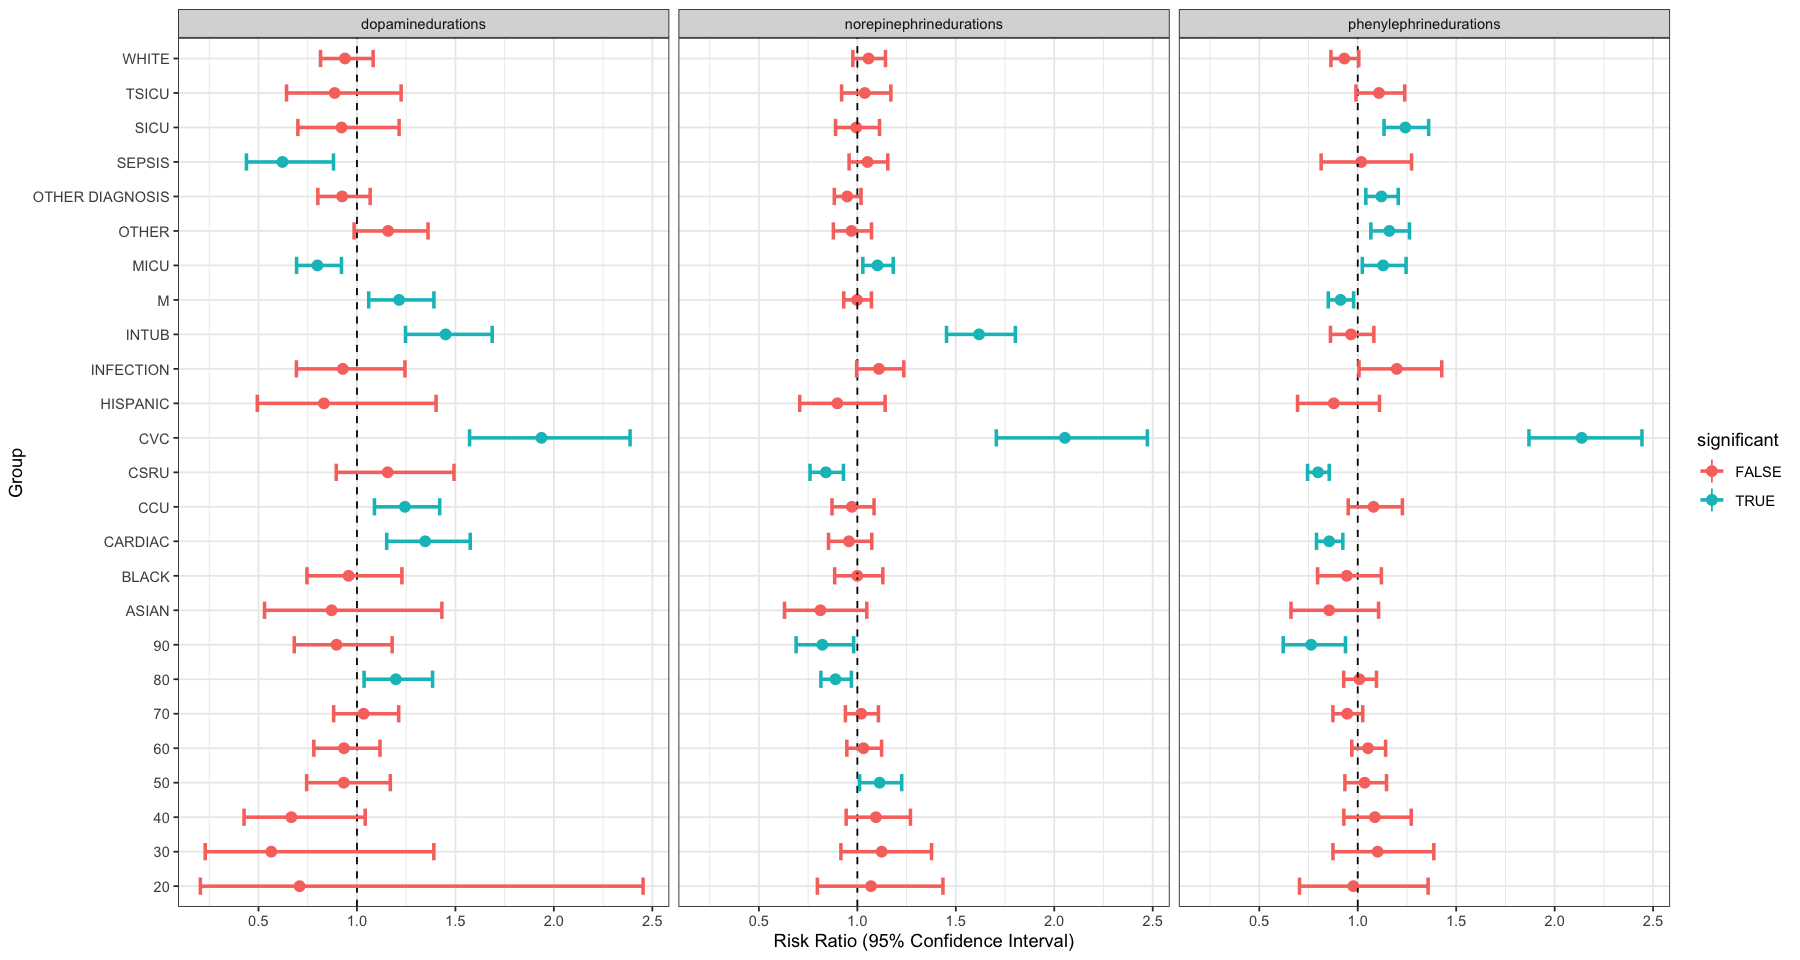

In [1178]:
options(repr.plot.width=15, repr.plot.height=8)
p = ggplot(data=pressor_rr_df,
    aes(x = ID,y = estimate, ymin = lower, ymax = upper ))+
    geom_pointrange(aes(col=significant))+
    geom_hline(yintercept =1, linetype=2)+
    xlab('Group')+ ylab("Risk Ratio (95% Confidence Interval)")+
    geom_errorbar(aes(ymin=lower, ymax=upper,col=significant),width=0.5,cex=1)+ 
    theme_bw() +
    coord_flip() + 
    facet_grid(. ~pressor)
plot(p)

# Vitals

### Pre-processing (30 minutes)

In [993]:
vitals_df <- read.csv('~/Projects/Haimovich_Pressors/collection/out/vitals.csv')

In [1298]:
# takes 6 mins to run (because of difftime)

vitals_merged_df <- vitals_df %>%
    mutate(charttime = fastPOSIXct(charttime)) %>%
    filter(icustay_id %in% output_df$icustay_id) %>%
    left_join(select(output_df, icustay_id, course_id, pressor, starttime, endtime, MORETHAN24HOURS, STATUS), by = "icustay_id") %>%
    rowwise() %>%
    mutate(diff = difftime(charttime, 
                       starttime, units="hours"))

In [1299]:
intervals <- 1:10

In [1300]:
results_list <- list()

In [1301]:
# takes 30 mins to run overall
for(interval in intervals){
    # 2 mins to run each
    results_list[[interval]] <- vitals_merged_df %>%
        filter(diff < 0) %>%
        filter(diff < -(interval - 1) & diff > -interval) %>%
        group_by(MORETHAN24HOURS, STATUS, course_id, pressor) %>%
        summarize(mean_heartrate = mean(heartrate, na.rm=T), 
                  mean_sysbp = mean(sysbp, na.rm=T),
                  mean_diasbp = mean(diasbp, na.rm=T),
                  mean_meanbp = mean(meanbp, na.rm=T), 
                  mean_resprate = mean(resprate, na.rm=T), 
                  mean_tempc = mean(tempc, na.rm=T), 
                  mean_spo2 = mean(spo2, na.rm=T), 
                  mean_glucose = mean(glucose, na.rm=T), 

                  median_heartrate = median(heartrate, na.rm=T), 
                  median_sysbp = median(sysbp, na.rm=T),
                  median_diasbp = median(diasbp, na.rm=T),
                  median_meanbp = median(meanbp, na.rm=T), 
                  median_resprate = median(resprate, na.rm=T), 
                  median_tempc = median(tempc, na.rm=T), 
                  median_spo2 = median(spo2, na.rm=T), 
                  median_glucose = median(glucose, na.rm=T),

                 ) %>%
        mutate(INTERVAL = interval)

}

Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message:
“Grouping rowwise data frame strips rowwise nature”

In [1302]:
results_df <- bind_rows(results_list) 

In [1303]:
melt_results_df <- results_df %>% 
    gather("ID", "VALUE", -course_id, -pressor, -MORETHAN24HOURS, -INTERVAL, -STATUS)

In [1304]:
head(melt_results_df,)

MORETHAN24HOURS,STATUS,course_id,pressor,INTERVAL,ID,VALUE
<lgl>,<chr>,<chr>,<fct>,<int>,<chr>,<dbl>
FALSE,LESSTHAN24HOURS,"200028,0",norepinephrinedurations,1,mean_heartrate,70.00000
FALSE,LESSTHAN24HOURS,"200030,0",norepinephrinedurations,1,mean_heartrate,84.33333
FALSE,LESSTHAN24HOURS,"200033,0",phenylephrinedurations,1,mean_heartrate,118.00000
FALSE,LESSTHAN24HOURS,"200065,0",norepinephrinedurations,1,mean_heartrate,121.50000
FALSE,LESSTHAN24HOURS,"200075,0",norepinephrinedurations,1,mean_heartrate,83.50000
FALSE,LESSTHAN24HOURS,"200078,0",phenylephrinedurations,1,mean_heartrate,100.00000


#### ANCOVA analysis using intervals
- MORETHAN24HOURS P-value tells you if this vital sign is a predictor (BP, HR, RR, TEMP)
- INTERVAL P-value tells you if these values change depending on the interval being measured (most values)
- MORETHAN24HOURS:INTERVAL P-value tells you if vital sign interacts with the interval being measured, that is, the extent of predictive value differs with time (BP especially, others are borderline significant)

In [1223]:
computeANCOVA <- function(df) {
    vitals_result_list <- list()
    for(vital in unique(melt_results_df$ID)){
        #cat("####", vital, "####")
        totest <- df %>%
             filter(ID == vital)
        test <- summary(aov(VALUE ~ MORETHAN24HOURS*INTERVAL, data = totest))[[1]]

        vitals_result_list[[vital]] <- data.frame(MORETHAN24HOURS = test["MORETHAN24HOURS ", "Pr(>F)"], 
                                                 INTERACTION = test["MORETHAN24HOURS:INTERVAL", "Pr(>F)"])
    }
    vitals_result_df <- bind_rows(vitals_result_list, .id="ID")
    
    return(vitals_result_df)
}

# Table 2 (Wilcox and ANCOVA Vitals)

In [1215]:
computeTest <- function(d, value="VALUE", comparison="GROUP"){
    paired_df <- d %>% 
        select(!!rlang::sym(comparison), !!rlang::sym(value)) 
    
    items <- unique(unlist(d[,comparison]))

    result_unpair <- t.test(filter(d, !!rlang::sym(comparison) == items[1])$VALUE, 
       filter(d, !!rlang::sym(comparison) == items[2])$VALUE, paired = FALSE)
    result_wilcox <- wilcox.test(filter(d, !!rlang::sym(comparison) == items[1])$VALUE, 
       filter(d, !!rlang::sym(comparison) == items[2])$VALUE, paired = FALSE)
    
    diff = mean(filter(d, !!rlang::sym(comparison) == items[1])$VALUE) -  
        mean(filter(d, !!rlang::sym(comparison) == items[2])$VALUE)
    
    return(data.frame(list(
                           'P_UNPAIR' = result_unpair$p.value, 
                           'P_WILCOX' = result_wilcox$p.value,
                            'GROUP1' = mean(filter(d, !!rlang::sym(comparison) == items[1])$VALUE),
                            'GROUP2' = mean(filter(d, !!rlang::sym(comparison) == items[2])$VALUE),
                            'DIFF' = diff,
                            'COMPARE' = paste(items[1], items[2], sep ='-'))))
}

In [1305]:
melt_results_df %>%
    filter(INTERVAL == 1) %>%
    drop_na(VALUE) %>%
    group_by(ID, STATUS) %>%
    summarize(MEAN = mean(VALUE), SD = sd(VALUE))

ID,STATUS,MEAN,SD
<chr>,<chr>,<dbl>,<dbl>
mean_diasbp,LESSTHAN24HOURS,55.22917,12.754692
mean_diasbp,LESSTHAN6HOURS,56.44289,13.747756
mean_diasbp,MORETHAN24HOURS,55.32072,13.377874
mean_glucose,LESSTHAN24HOURS,148.90861,64.971211
mean_glucose,LESSTHAN6HOURS,147.99218,62.926642
mean_glucose,MORETHAN24HOURS,150.25696,69.631472
mean_heartrate,LESSTHAN24HOURS,89.10626,19.471682
mean_heartrate,LESSTHAN6HOURS,87.34313,19.563885
mean_heartrate,MORETHAN24HOURS,91.08273,20.624659


In [1216]:
melt_results_df %>%
    filter(INTERVAL == 1) %>%
    drop_na(VALUE) %>%
    group_by(ID) %>%
    do(computeTest(.,value="VALUE", comparison="MORETHAN24HOURS")) %>%
    mutate(significant = P_WILCOX < 0.05)

ID,P_UNPAIR,P_WILCOX,GROUP1,GROUP2,DIFF,COMPARE,significant
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<lgl>
mean_diasbp,6.138732e-02,4.060692e-03,55.82784,55.32072,0.50712280,FALSE-TRUE,TRUE
mean_glucose,3.284543e-01,8.168638e-01,148.45337,150.25696,-1.80358930,FALSE-TRUE,FALSE
mean_heartrate,4.098007e-12,1.209843e-14,88.23731,91.08273,-2.84541295,FALSE-TRUE,TRUE
mean_meanbp,1.647502e-04,4.993955e-08,72.25716,71.07429,1.18286758,FALSE-TRUE,TRUE
mean_resprate,9.060219e-21,2.637535e-23,17.38850,18.46853,-1.08002430,FALSE-TRUE,TRUE
mean_spo2,3.771532e-04,1.784907e-13,97.46784,97.11629,0.35154329,FALSE-TRUE,TRUE
mean_sysbp,1.384325e-09,8.150123e-16,106.99935,104.49804,2.50130684,FALSE-TRUE,TRUE
mean_tempc,1.641980e-02,4.810184e-02,36.37568,36.45664,-0.08096468,FALSE-TRUE,TRUE
median_diasbp,6.721541e-02,6.127488e-03,55.64028,55.13805,0.50223075,FALSE-TRUE,TRUE


In [1219]:
pressor_choices

[1] "norepinephrinedurations" "dopaminedurations"      
[3] "phenylephrinedurations"

In [ ]:
melt_results_df %>%
    group_by(pressor) %>%
    filter(INTERVAL == 1) %>%
    drop_na(VALUE) %>%
    group_by(ID) %>%
    do(computeTest(.,value="VALUE", comparison="MORETHAN24HOURS")) %>%
    mutate(significant = P_WILCOX < 0.05)

In [1218]:
melt_results_df %>%
    filter(INTERVAL == 1, pressor == pressor_choices[1]) %>%
    drop_na(VALUE) %>%
    group_by(ID) %>%
    do(computeTest(.,value="VALUE", comparison="MORETHAN24HOURS")) %>%
    mutate(significant = P_WILCOX < 0.05)

ID,P_UNPAIR,P_WILCOX,GROUP1,GROUP2,DIFF,COMPARE,significant
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<lgl>
mean_diasbp,3.331572e-02,1.472646e-02,55.35264,54.23575,1.11688226,FALSE-TRUE,TRUE
mean_glucose,5.724678e-01,5.858557e-01,166.18769,163.63953,2.54815444,FALSE-TRUE,FALSE
mean_heartrate,4.209055e-09,3.892865e-10,91.15775,95.44150,-4.28375570,FALSE-TRUE,TRUE
mean_meanbp,6.390642e-04,3.120962e-05,70.09268,68.15919,1.93349593,FALSE-TRUE,TRUE
mean_resprate,2.237160e-07,1.198224e-07,19.17722,20.24327,-1.06605115,FALSE-TRUE,TRUE
mean_spo2,2.908707e-01,1.596030e-04,96.52805,96.31018,0.21787028,FALSE-TRUE,TRUE
mean_sysbp,2.525364e-06,5.879073e-08,104.30735,100.84525,3.46209502,FALSE-TRUE,TRUE
mean_tempc,2.014236e-01,2.669722e-01,36.44807,36.53375,-0.08568111,FALSE-TRUE,FALSE
median_diasbp,3.693948e-02,1.822012e-02,55.17304,54.06702,1.10601563,FALSE-TRUE,TRUE


In [1220]:
melt_results_df %>%
    filter(INTERVAL == 1, pressor == pressor_choices[2]) %>%
    drop_na(VALUE) %>%
    group_by(ID) %>%
    do(computeTest(.,value="VALUE", comparison="MORETHAN24HOURS")) %>%
    mutate(significant = P_WILCOX < 0.05)

ID,P_UNPAIR,P_WILCOX,GROUP1,GROUP2,DIFF,COMPARE,significant
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<lgl>
mean_diasbp,7.491091e-01,0.7725920931,52.74566,52.49037,0.25528178,FALSE-TRUE,FALSE
mean_glucose,4.325789e-01,0.7471496311,189.25146,197.37073,-8.11926451,FALSE-TRUE,FALSE
mean_heartrate,1.748709e-05,0.0001520699,87.54812,82.46981,5.07830922,FALSE-TRUE,TRUE
mean_meanbp,9.559600e-01,0.8936009876,68.48293,68.43626,0.04667180,FALSE-TRUE,FALSE
mean_resprate,2.659670e-01,0.1537316352,19.57734,19.24126,0.33607723,FALSE-TRUE,FALSE
mean_spo2,9.746676e-01,0.6726860836,95.79885,95.80932,-0.01047334,FALSE-TRUE,FALSE
mean_sysbp,9.293400e-01,0.7158132465,103.00194,103.10880,-0.10685946,FALSE-TRUE,FALSE
mean_tempc,3.151158e-01,0.3499326341,36.38069,36.25883,0.12186085,FALSE-TRUE,FALSE
median_diasbp,6.561762e-01,0.7357121130,52.46060,52.10127,0.35932391,FALSE-TRUE,FALSE


In [1221]:
melt_results_df %>%
    filter(INTERVAL == 1, pressor == pressor_choices[3]) %>%
    drop_na(VALUE) %>%
    group_by(ID) %>%
    do(computeTest(.,value="VALUE", comparison="MORETHAN24HOURS")) %>%
    mutate(significant = P_WILCOX < 0.05)

ID,P_UNPAIR,P_WILCOX,GROUP1,GROUP2,DIFF,COMPARE,significant
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<lgl>
mean_diasbp,6.573965e-01,8.676829e-01,56.76535,56.91517,-0.14982833,FALSE-TRUE,FALSE
mean_glucose,1.344892e-01,2.113312e-01,139.03491,136.80189,2.23301365,FALSE-TRUE,FALSE
mean_heartrate,3.247646e-06,6.922868e-07,87.24458,89.77436,-2.52978070,FALSE-TRUE,TRUE
mean_meanbp,8.740591e-01,5.400202e-01,74.02249,74.08884,-0.06635117,FALSE-TRUE,FALSE
mean_resprate,3.013890e-06,1.778886e-06,16.19393,16.89128,-0.69734208,FALSE-TRUE,TRUE
mean_spo2,1.452008e-01,1.768035e-04,98.21138,98.05359,0.15778891,FALSE-TRUE,TRUE
mean_sysbp,2.313974e-02,2.925267e-04,109.03696,107.78944,1.24752164,FALSE-TRUE,TRUE
mean_tempc,3.330833e-02,1.637219e-01,36.35048,36.43682,-0.08633886,FALSE-TRUE,FALSE
median_diasbp,6.084885e-01,8.137525e-01,56.59836,56.77389,-0.17553259,FALSE-TRUE,FALSE


In [1224]:
vitals_result_df <- computeANCOVA(melt_results_df)
vitals_result_df %>% mutate(
    significant = MORETHAN24HOURS < 0.05, 
    significant_interaction = INTERACTION < 0.05)

ID,MORETHAN24HOURS,INTERACTION,significant,significant_interaction
<chr>,<dbl>,<dbl>,<lgl>,<lgl>
mean_heartrate,1.243038e-30,0.1132776475,TRUE,FALSE
mean_sysbp,7.346551e-44,0.0006181598,TRUE,TRUE
mean_diasbp,9.278100e-07,0.1945913337,TRUE,FALSE
mean_meanbp,2.076218e-15,0.4030909834,TRUE,FALSE
mean_resprate,2.683617e-64,0.0097918982,TRUE,TRUE
mean_tempc,1.659301e-03,0.4450229830,TRUE,FALSE
mean_spo2,2.522526e-16,0.6961708305,TRUE,FALSE
mean_glucose,1.255091e-02,0.9446338630,TRUE,FALSE
median_heartrate,6.473798e-31,0.0976214620,TRUE,FALSE


In [1225]:
pressors_vitals_rr_list <- list()
for(pressor_choice in pressor_choices){
    pressors_vitals_rr_list[[pressor_choice]] <- melt_results_df %>%
        filter(pressor == pressor_choice) %>%
        computeANCOVA() %>%
        mutate(
            significant = MORETHAN24HOURS < 0.05,
            significant_interaction = INTERACTION < 0.05)
}

pressors_vitals_rr_df <- bind_rows(pressors_vitals_rr_list, .id="pressor")

In [1226]:
pressors_vitals_rr_df

pressor,ID,MORETHAN24HOURS,INTERACTION,significant,significant_interaction
<chr>,<chr>,<dbl>,<dbl>,<lgl>,<lgl>
norepinephrinedurations,mean_heartrate,1.776750e-16,0.0966926912,TRUE,FALSE
norepinephrinedurations,mean_sysbp,6.988496e-34,0.0004413466,TRUE,TRUE
norepinephrinedurations,mean_diasbp,6.919672e-07,0.1772755175,TRUE,FALSE
norepinephrinedurations,mean_meanbp,5.139855e-15,0.0570921050,TRUE,FALSE
norepinephrinedurations,mean_resprate,1.309683e-33,0.7703809526,TRUE,FALSE
norepinephrinedurations,mean_tempc,9.887433e-02,0.6052734835,FALSE,FALSE
norepinephrinedurations,mean_spo2,1.543707e-01,0.2615521256,FALSE,FALSE
norepinephrinedurations,mean_glucose,6.711331e-01,0.5167688012,FALSE,FALSE
norepinephrinedurations,median_heartrate,2.162075e-16,0.0885995356,TRUE,FALSE


# Figure 2 ANCOVA Plotting

In [1227]:
toplot <- melt_results_df %>%
    mutate(INTERVAL = -INTERVAL) %>%
    drop_na(VALUE) %>%
    filter(grepl("mean_", ID), ID != "mean_diasbp", ID != "mean_sysbp")

In [1228]:
options(repr.plot.width=10, repr.plot.height=3)

g <- ggplot(toplot, 
            aes(x=toplot$INTERVAL, y=toplot$VALUE, color=factor(toplot$MORETHAN24HOURS))) +
#geom_point() + 
geom_smooth(method=lm, aes(fill=factor(toplot$MORETHAN24HOURS))) + 
xlab("Hours before pressors") + ylab("Value") +
theme_classic() + theme(legend.title = element_blank()) +
facet_wrap(. ~ ID, scale="free", nrow=1)

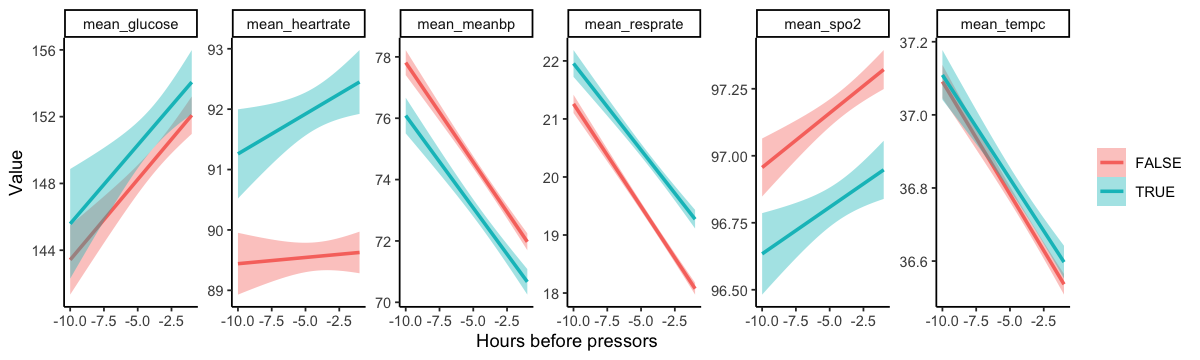

In [1229]:
plot(g)

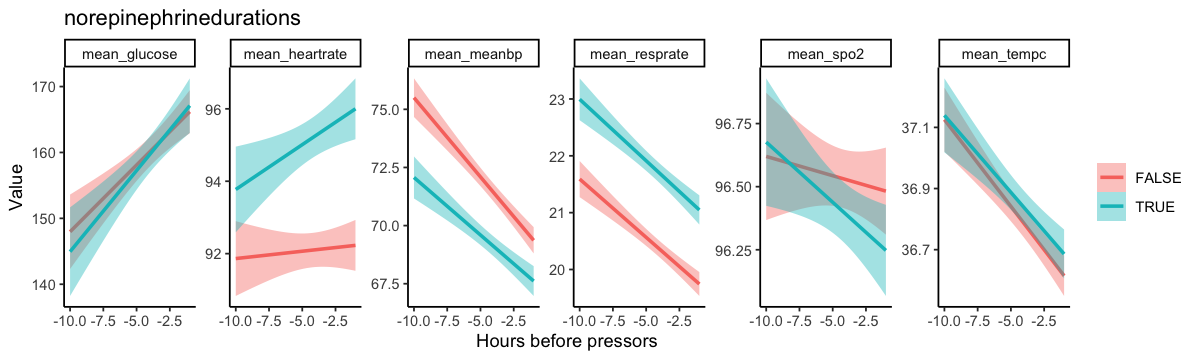

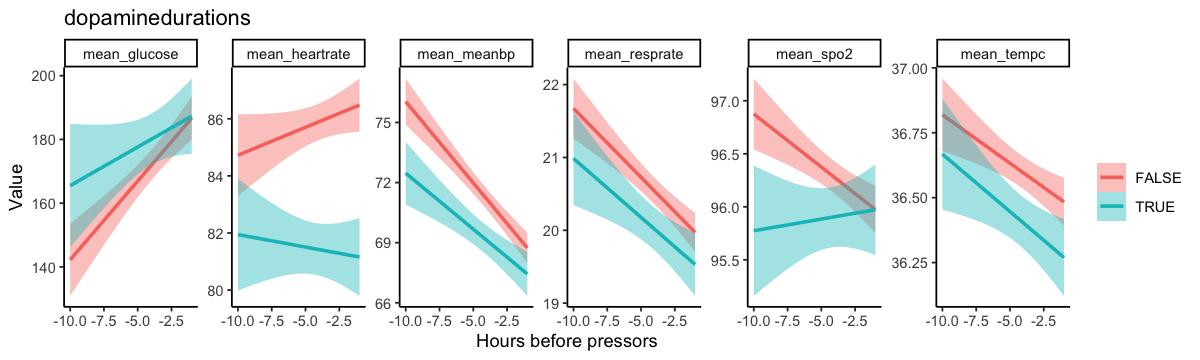

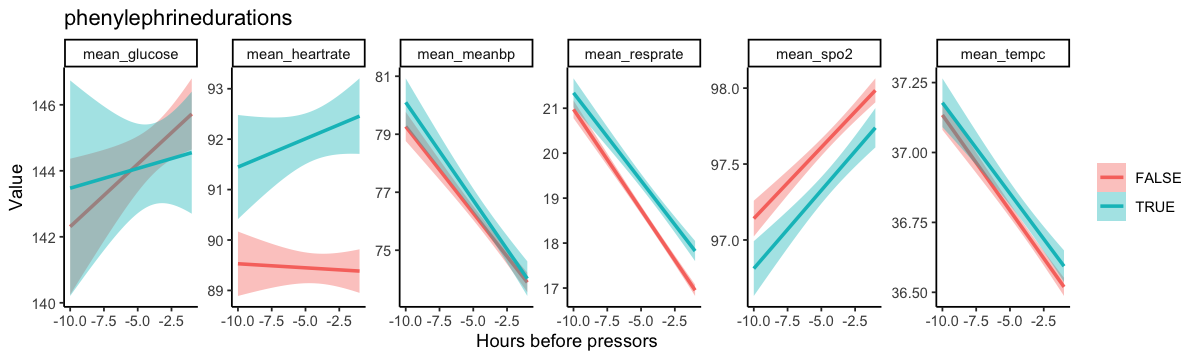

In [1230]:
for(pressor_choice in pressor_choices){
    toplot <- melt_results_df %>%
        mutate(INTERVAL = -INTERVAL) %>%
        drop_na(VALUE) %>%
        filter(pressor == pressor_choice, grepl("mean_", ID), ID != "mean_diasbp", ID != "mean_sysbp")
    
    g <- ggplot(toplot, 
            aes(x=toplot$INTERVAL, y=toplot$VALUE, color=factor(toplot$MORETHAN24HOURS))) +
    #geom_point() + 
    ggtitle(pressor_choice) +
    geom_smooth(method=lm, aes(fill=factor(toplot$MORETHAN24HOURS))) + 
    xlab("Hours before pressors") + ylab("Value") +
    theme_classic() + theme(legend.title = element_blank()) +
    facet_wrap(. ~ ID, scale="free", nrow=1)
    
    plot(g)
}

# LR Model for Total
- Running into problems with missing data for glucose, spo2 and tempc. 

In [1242]:
model_input_df <- melt_results_df %>%
    filter(INTERVAL < 4) %>%
    ungroup() %>%
    mutate(VARIABLE = paste(ID, INTERVAL, sep = '_'), COURSE = course_id, RESPONSE = MORETHAN24HOURS) %>%
    select(RESPONSE, COURSE, VARIABLE, VALUE, pressor) %>%
    mutate(VALUE = as.character(VALUE)) %>%
    bind_rows(
        output_df %>% 
            select(MORETHAN24HOURS, pressor, course_id, first_careunit, cvc, intub, simple_race, simple_diagnosis, gender, age_cohort) %>%
            gather(VARIABLE, VALUE, -MORETHAN24HOURS, -course_id, -pressor) %>%
            rename(RESPONSE = MORETHAN24HOURS, COURSE = course_id) %>%
            distinct(ICUSTAY, VARIABLE, VALUE, pressor, .keep_all = TRUE)
    ) %>%
    drop_na(VALUE) %>%
    spread(VARIABLE, VALUE) %>% 
    select(-COURSE, -pressor)

Warning message:
“attributes are not identical across measure variables;
they will be dropped”Warning message:
“Trying to compute distinct() for variables not found in the data:
- `ICUSTAY`
This is an error, but only a warning is raised for compatibility reasons.
The following variables will be used:
- VARIABLE
- VALUE
- pressor”

In [1243]:
# decide the input parameters for model
model_input_df <- model_input_df %>%
    mutate_at(vars(contains("mean_")), as.numeric, na.rm = TRUE) %>%
    mutate_at(vars(contains("median_")), as.numeric, na.rm = TRUE) %>%
    mutate(age_cohort = as.numeric(age_cohort)) %>%
    select(RESPONSE, 
             first_careunit,
             cvc,
             intub,
             simple_diagnosis,
             simple_race, 
             age_cohort,
             gender,
             age_cohort, 
             contains("mean_meanbp"),
             contains("mean_resprate"),
             contains("mean_heartrate"),
              )

In [1244]:
model_input_df <- model_input_df[which(complete.cases(model_input_df)),]

In [1245]:
dim(model_input_df)

[1] 3239   17

In [1246]:
model <- glm(RESPONSE ~ . , family=binomial(link='logit'),data=model_input_df)

In [1247]:
summary(model)


Call:
glm(formula = RESPONSE ~ ., family = binomial(link = "logit"), 
    data = model_input_df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.4449  -0.9402  -0.7746   1.3150   2.2620  

Coefficients:
                                  Estimate Std. Error z value Pr(>|z|)    
(Intercept)                     -1.0437362  0.4528405  -2.305 0.021174 *  
first_careunitCSRU              -0.4755656  0.1379736  -3.447 0.000567 ***
first_careunitMICU              -0.0350084  0.1293241  -0.271 0.786619    
first_careunitSICU              -0.1775750  0.1468977  -1.209 0.226726    
first_careunitTSICU             -0.2295518  0.1566553  -1.465 0.142831    
cvcTRUE                          1.0809910  0.1541018   7.015  2.3e-12 ***
intubTRUE                        0.1354220  0.1155532   1.172 0.241219    
simple_diagnosisINFECTION        0.0653046  0.1828412   0.357 0.720968    
simple_diagnosisOTHER DIAGNOSIS -0.0975883  0.1267683  -0.770 0.441409    
simple_diagnosisSEPSIS 

In [1250]:
k <- 3
kfCV <- cv.glm(data=model_input_df, glmfit=model, K=k)

In [1251]:
accuracy <- 1 - kfCV$delta[1]

In [1252]:
accuracy

[1] 0.7832692

# LR Model for norepinephrine
- Running into problems with missing data for glucose, spo2 and tempc. 

In [1263]:
model_input_df <- melt_results_df %>%
    filter(pressor == 'norepinephrinedurations') %>%
    select(-pressor) %>%
    filter(INTERVAL < 4) %>%
    ungroup() %>%
    mutate(VARIABLE = paste(ID, INTERVAL, sep = '_'), COURSE = course_id, RESPONSE = MORETHAN24HOURS) %>%
    select(RESPONSE, COURSE, VARIABLE, VALUE) %>%
    mutate(VALUE = as.character(VALUE)) %>%
    bind_rows(
        output_df %>% 
            filter(pressor == 'norepinephrinedurations') %>%
            select(-pressor) %>%
            select(MORETHAN24HOURS, course_id, first_careunit, cvc, intub, simple_race, simple_diagnosis, gender, age_cohort) %>%
            gather(VARIABLE, VALUE, -MORETHAN24HOURS, -course_id) %>%
            rename(RESPONSE = MORETHAN24HOURS, COURSE = course_id) %>%
            distinct(COURSE, VARIABLE, VALUE, .keep_all = TRUE)
    ) %>%
    drop_na(VALUE) %>%
    spread(VARIABLE, VALUE) %>% 
    select(-COURSE)

Warning message:
“attributes are not identical across measure variables;
they will be dropped”

In [1264]:
model_input_df <- model_input_df %>%
    mutate_at(vars(contains("mean_")), as.numeric, na.rm = TRUE) %>%
    mutate_at(vars(contains("median_")), as.numeric, na.rm = TRUE) %>%
    mutate(age_cohort = as.numeric(age_cohort)) %>%
    select(RESPONSE, 
             first_careunit,
             cvc,
             intub,
             simple_diagnosis,
             simple_race, 
             age_cohort,
             gender,
             age_cohort, 
             contains("mean_meanbp"),
             contains("mean_resprate"),
             contains("mean_heartrate"),
              )

In [1265]:
model_input_df <- model_input_df[which(complete.cases(model_input_df)),]

In [1266]:
dim(model_input_df)

[1] 980  17

In [1267]:
model <- glm(RESPONSE ~ . , family=binomial(link='logit'),data=model_input_df)

In [1268]:
summary(model)


Call:
glm(formula = RESPONSE ~ ., family = binomial(link = "logit"), 
    data = model_input_df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.6937  -1.0591  -0.7577   1.1790   1.8623  

Coefficients:
                                 Estimate Std. Error z value Pr(>|z|)   
(Intercept)                     -0.054737   0.844632  -0.065  0.94833   
first_careunitCSRU              -0.334760   0.328390  -1.019  0.30802   
first_careunitMICU               0.137872   0.231150   0.596  0.55087   
first_careunitSICU               0.010888   0.296075   0.037  0.97067   
first_careunitTSICU              0.012908   0.305258   0.042  0.96627   
cvcTRUE                          0.776198   0.361199   2.149  0.03164 * 
intubTRUE                        0.387415   0.191502   2.023  0.04307 * 
simple_diagnosisINFECTION       -0.332697   0.332769  -1.000  0.31741   
simple_diagnosisOTHER DIAGNOSIS -0.638259   0.287694  -2.219  0.02652 * 
simple_diagnosisSEPSIS          -0.831398  

In [1269]:
k <- 3
kfCV <- cv.glm(data=model_input_df, glmfit=model, K=k)

In [1270]:
accuracy <- 1 - kfCV$delta[1]

In [1271]:
accuracy

[1] 0.7587459

# LR Model for dopamine

In [1272]:
model_input_df <- melt_results_df %>%
    filter(pressor == 'dopaminedurations') %>%
    select(-pressor) %>%
    filter(INTERVAL < 4) %>%
    ungroup() %>%
    mutate(VARIABLE = paste(ID, INTERVAL, sep = '_'), COURSE = course_id, RESPONSE = MORETHAN24HOURS) %>%
    select(RESPONSE, COURSE, VARIABLE, VALUE) %>%
    mutate(VALUE = as.character(VALUE)) %>%
    bind_rows(
        output_df %>% 
            filter(pressor == 'dopaminedurations') %>%
            select(-pressor) %>%
            select(MORETHAN24HOURS, course_id, first_careunit, cvc, intub, simple_race, simple_diagnosis, gender, age_cohort) %>%
            gather(VARIABLE, VALUE, -MORETHAN24HOURS, -course_id) %>%
            rename(RESPONSE = MORETHAN24HOURS, COURSE = course_id) %>%
            distinct(COURSE, VARIABLE, VALUE, .keep_all = TRUE)
    ) %>%
    drop_na(VALUE) %>%
    spread(VARIABLE, VALUE) %>% 
    select(-COURSE)

Warning message:
“attributes are not identical across measure variables;
they will be dropped”

In [1273]:
model_input_df <- model_input_df %>%
    mutate_at(vars(contains("mean_")), as.numeric, na.rm = TRUE) %>%
    mutate_at(vars(contains("median_")), as.numeric, na.rm = TRUE) %>%
    mutate(age_cohort = as.numeric(age_cohort)) %>%
    select(RESPONSE, 
             first_careunit,
             cvc,
             intub,
             simple_diagnosis,
             simple_race, 
             age_cohort,
             gender,
             age_cohort, 
             contains("mean_meanbp"),
             contains("mean_resprate"),
             contains("mean_heartrate"),
              )

In [1274]:
model_input_df <- model_input_df[which(complete.cases(model_input_df)),]

In [1275]:
dim(model_input_df)

[1] 417  17

In [1276]:
model <- glm(RESPONSE ~ . , family=binomial(link='logit'),data=model_input_df)

In [1277]:
summary(model)


Call:
glm(formula = RESPONSE ~ ., family = binomial(link = "logit"), 
    data = model_input_df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.4700  -0.8292  -0.6129   1.0399   2.2518  

Coefficients:
                                 Estimate Std. Error z value Pr(>|z|)  
(Intercept)                      1.708706   1.414552   1.208   0.2271  
first_careunitCSRU              -0.566722   0.490302  -1.156   0.2477  
first_careunitMICU              -0.351015   0.276136  -1.271   0.2037  
first_careunitSICU              -0.145932   0.483690  -0.302   0.7629  
first_careunitTSICU             -2.010244   1.058257  -1.900   0.0575 .
cvcTRUE                          0.940164   0.377532   2.490   0.0128 *
intubTRUE                        0.054728   0.282856   0.193   0.8466  
simple_diagnosisINFECTION       -0.223517   0.514585  -0.434   0.6640  
simple_diagnosisOTHER DIAGNOSIS -0.354349   0.323959  -1.094   0.2740  
simple_diagnosisSEPSIS          -0.738412   0.721544 

In [1278]:
k <- 3
kfCV <- cv.glm(data=model_input_df, glmfit=model, K=k)

In [1279]:
accuracy <- 1 - kfCV$delta[1]

In [1280]:
accuracy

[1] 0.7857751

# LR Model for Phenylephrine

In [1281]:
pressor_choice <- 'phenylephrinedurations'

In [1282]:
model_input_df <- melt_results_df %>%
    filter(pressor == pressor_choice) %>%
    select(-pressor) %>%
    filter(INTERVAL < 4) %>%
    ungroup() %>%
    mutate(VARIABLE = paste(ID, INTERVAL, sep = '_'), COURSE = course_id, RESPONSE = MORETHAN24HOURS) %>%
    select(RESPONSE, COURSE, VARIABLE, VALUE) %>%
    mutate(VALUE = as.character(VALUE)) %>%
    bind_rows(
        output_df %>% 
            filter(pressor == pressor_choice) %>%
            select(-pressor) %>%
            select(MORETHAN24HOURS, course_id, first_careunit, cvc, intub, simple_race, simple_diagnosis, gender, age_cohort) %>%
            gather(VARIABLE, VALUE, -MORETHAN24HOURS, -course_id) %>%
            rename(RESPONSE = MORETHAN24HOURS, COURSE = course_id) %>%
            distinct(COURSE, VARIABLE, VALUE, .keep_all = TRUE)
    ) %>%
    drop_na(VALUE) %>%
    spread(VARIABLE, VALUE) %>% 
    select(-COURSE)

Warning message:
“attributes are not identical across measure variables;
they will be dropped”

In [1283]:
model_input_df <- model_input_df %>%
    mutate_at(vars(contains("mean_")), as.numeric, na.rm = TRUE) %>%
    mutate_at(vars(contains("median_")), as.numeric, na.rm = TRUE) %>%
    mutate(age_cohort = as.numeric(age_cohort)) %>%
    select(RESPONSE, 
             first_careunit,
             cvc,
             intub,
             simple_diagnosis,
             simple_race, 
             age_cohort,
             gender,
             age_cohort, 
             contains("mean_meanbp"),
             contains("mean_resprate"),
             contains("mean_heartrate"),
              )

In [1284]:
model_input_df <- model_input_df[which(complete.cases(model_input_df)),]

In [1285]:
dim(model_input_df)

[1] 1842   17

In [1286]:
model <- glm(RESPONSE ~ . , family=binomial(link='logit'),data=model_input_df)

In [1287]:
summary(model)


Call:
glm(formula = RESPONSE ~ ., family = binomial(link = "logit"), 
    data = model_input_df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.4447  -0.8662  -0.7226   1.2876   2.3237  

Coefficients:
                                  Estimate Std. Error z value Pr(>|z|)    
(Intercept)                     -2.3621986  0.6561366  -3.600 0.000318 ***
first_careunitCSRU              -0.3213438  0.2057406  -1.562 0.118314    
first_careunitMICU              -0.1904254  0.2279918  -0.835 0.403589    
first_careunitSICU              -0.1693752  0.2184279  -0.775 0.438087    
first_careunitTSICU             -0.1838404  0.2289244  -0.803 0.421939    
cvcTRUE                          1.1766198  0.1981361   5.938 2.88e-09 ***
intubTRUE                       -0.0564426  0.1812830  -0.311 0.755534    
simple_diagnosisINFECTION       -0.0268089  0.2976356  -0.090 0.928229    
simple_diagnosisOTHER DIAGNOSIS  0.0643062  0.1643594   0.391 0.695610    
simple_diagnosisSEPSIS 

In [1295]:
exp(cbind(coef(model), confint(model)))

Waiting for profiling to be done...


,,2.5 %,97.5 %
(Intercept),0.09421286,0.02571675,0.3374939
first_careunitCSRU,0.72517388,0.48625977,1.0907015
first_careunitMICU,0.82660743,0.52980675,1.2964970
first_careunitSICU,0.84419214,0.55173837,1.3005264
first_careunitTSICU,0.83206863,0.53222622,1.3072365
cvcTRUE,3.24339231,2.22852778,4.8558885
intubTRUE,0.94512076,0.66531336,1.3557187
simple_diagnosisINFECTION,0.97354728,0.53730403,1.7308050
simple_diagnosisOTHER DIAGNOSIS,1.06641886,0.77402228,1.4751311
simple_diagnosisSEPSIS,0.21205626,0.04846702,0.6481761


In [1288]:
k <- 3
kfCV <- cv.glm(data=model_input_df, glmfit=model, K=k)

In [1289]:
accuracy <- 1 - kfCV$delta[1]

In [1290]:
accuracy

[1] 0.7984461